In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wEURN9qLpgxqRhIpLwwXUfB57nc7qjBs4t9bqgxyjpjy-X3SmqdTrI
Mounted at /content/drive


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [225]:
import pickle
import numpy as np
import pandas as pd

In [345]:
data = pd.read_excel("/content/drive/My Drive/Munna_Research/Experiment/ecdata_new.xlsx", encoding='utf-8')

In [346]:
data = data[['comments', 'catagories']]

In [347]:
data.shape

(5109, 2)

In [348]:
data.catagories.value_counts()

c    1908
r    1562
a    1185
w     454
Name: catagories, dtype: int64

In [349]:
map = {
    'c': 'Complain',
    'w': 'Wrong delivery',
    'r': 'Recommended',
    'a': 'Appreciation'
}

data.catagories = data.catagories.map(map)

In [350]:
data.catagories.value_counts()

Complain          1908
Recommended       1562
Appreciation      1185
Wrong delivery     454
Name: catagories, dtype: int64

## Preprocessing

In [351]:
%%time
import re
data['texts_prep'] = data.comments.apply(lambda x: [i for i in re.sub(r'[^\u0980-\u09E3 A-Za-z]+', ' ', str(x)).split() if len(i) > 1])

CPU times: user 33.5 ms, sys: 3.02 ms, total: 36.5 ms
Wall time: 37.5 ms


In [352]:
data = data[data.texts_prep.apply(lambda x: len(x)) > 0]

In [353]:
## Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['target'] = le.fit_transform(data['catagories'].copy().tolist())

In [354]:
data[['catagories', 'target']].drop_duplicates(subset=['catagories']).sort_values(by=['target']).reset_index(drop=True)

,catagories,target
0,Appreciation,0
1,Complain,1
2,Recommended,2
3,Wrong delivery,3


In [236]:
# !pip install bnlp_toolkit

In [237]:
data.head(3)

,comments,catagories,texts_prep,target
0,Recommended but phone battery cover is not as ...,appreciation,"[Recommended, but, phone, battery, cover, is, ...",0
1,thanks a lot but what is the problem you guys ...,appreciation,"[thanks, lot, but, what, is, the, problem, you...",0
2,মাত্র ১১ দিনে ডেলিভারি পেয়েছি সে জন্য দারাজকে ...,appreciation,"[মাত্র, দিনে, ডেলিভারি, পেয়েছি, সে, জন্য, দারা...",0


## Data Partitioning

In [258]:
X = data['texts_prep']
y = data['target']

In [259]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=0, stratify=y_val)

print("""Training shape: {}
Validation shape: {}
Testing shape: {}""".format(X_train.shape, X_val.shape, X_test.shape))

Training shape: (3574,)
Validation shape: (1073,)
Testing shape: (460,)


## Load fastText pre-trained model

In [30]:
!unzip "/content/drive/My Drive/Munna_Research/Experiment/cc.bn.300.zip" -d /content

Archive:  /content/drive/My Drive/Munna_Research/Experiment/cc.bn.300.zip
  inflating: /content/cc.bn.300.vec  


In [31]:
from gensim.models import KeyedVectors

path = '/content/cc.bn.300.vec'
fastText_model = KeyedVectors.load_word2vec_format(path, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Feature Extraction

In [239]:
def embedding_vectorizer(fastText_model, docs):
    mean_vecs = []
    for instance in docs:
        vecs = []
        for word in instance:
            if word in fastText_model.vocab:
                vecs.append(fastText_model[word])
            else:
                vecs.append(np.zeros(fastText_model.vector_size))
                
        mean_vecs.append(np.mean(vecs, axis=0))
        
    return mean_vecs

In [260]:
x_train_vectorized = embedding_vectorizer(fastText_model, X_train)
x_train_vectorized = pd.DataFrame(x_train_vectorized).add_prefix('col_')

In [261]:
x_val_vectorized = embedding_vectorizer(fastText_model, X_val)
x_val_vectorized = pd.DataFrame(x_val_vectorized).add_prefix('col_')

In [262]:
x_test_vectorized = embedding_vectorizer(fastText_model, X_test)
x_test_vectorized = pd.DataFrame(x_test_vectorized).add_prefix('col_')

In [263]:
from keras.utils import to_categorical

y_train_k = to_categorical(y_train, num_classes=4)
y_val_k = to_categorical(y_val, num_classes=4)
y_test_k = to_categorical(y_test, num_classes=4)

In [264]:
import tensorflow as tf
import random as rn

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import History
from keras.optimizers import Adam, SGD

In [297]:
np.random.seed(2)
rn.seed(3)

history = History()

model = Sequential()
model.add(Dense(1024, input_dim=300, activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(4, activation="softmax"))

model.compile(optimizer=Adam(0.0001), loss="categorical_crossentropy", metrics=['accuracy'])
# model.summary()

model.fit(np.array(x_train_vectorized), np.array(y_train_k), 
          validation_data=(np.array(x_val_vectorized), np.array(y_val_k)), 
          epochs=150, 
          batch_size=2000, 
          shuffle=True, 
          callbacks=[history], 
          verbose=True)

Train on 3574 samples, validate on 1073 samples
Epoch 1/150
3574/3574 [==============================] - 2s 439us/step - loss: 1.4012 - accuracy: 0.2490 - val_loss: 1.3593 - val_accuracy: 0.3830
Epoch 2/150
3574/3574 [==============================] - 0s 12us/step - loss: 1.3710 - accuracy: 0.2890 - val_loss: 1.3244 - val_accuracy: 0.4082
Epoch 3/150
3574/3574 [==============================] - 0s 10us/step - loss: 1.3344 - accuracy: 0.3559 - val_loss: 1.2963 - val_accuracy: 0.4119
Epoch 4/150
3574/3574 [==============================] - 0s 10us/step - loss: 1.3141 - accuracy: 0.3811 - val_loss: 1.2742 - val_accuracy: 0.4194
Epoch 5/150
3574/3574 [==============================] - 0s 12us/step - loss: 1.2981 - accuracy: 0.3811 - val_loss: 1.2572 - val_accuracy: 0.4185
Epoch 6/150
3574/3574 [==============================] - 0s 11us/step - loss: 1.2760 - accuracy: 0.4088 - val_loss: 1.2442 - val_accuracy: 0.4203
Epoch 7/150
3574/3574 [==============================] - 0s 11us/step - los

In [299]:
# import pickle
# with open("/content/drive/My Drive/Munna_Research/Experiment/model_2.rifat", 'wb') as out_file:
#  pickle.dump(model, out_file)

In [ ]:
# from sklearn.externals import joblib

# # save the model to disk
# filename = "/content/drive/My Drive/Munna_Research/Experiment/model_1.joblib"
# joblib.dump(model, filename)

In [300]:
# for visualization
his_train_acc = history.history['accuracy']
his_val_acc = history.history['val_accuracy']

his_train_loss = history.history['loss']
his_val_loss = history.history['val_loss']

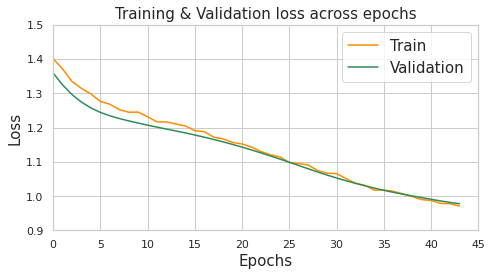

In [329]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(7,4))
plt.plot(his_train_loss[:44],'darkorange')
plt.plot(his_val_loss[:44], 'seagreen')

plt.title("Training & Validation loss across epochs",fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=15)
plt.legend(['Train', 'Validation'], fontsize=15 ,loc='upper right')
plt.xlim(0,45)
plt.ylim(0.9, 1.5)
plt.tight_layout()
# plt.savefig("multiclass_loss_vs_epochs_fastText_munna.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [330]:
loss, test_accuracy = model.evaluate(np.array(x_test_vectorized), np.array(y_test_k), verbose=0)

In [333]:
train_accuracy = his_train_acc[-1]
val_accuracy = his_val_acc[-1]

accuracy_table = pd.DataFrame([round(train_accuracy, 2), round(val_accuracy, 2), round(test_accuracy, 2)], 
             index=['Training', 'Validation', 'Test'], 
             columns=['Accuracy'])
accuracy_table

,Accuracy
Training,0.70
Validation,0.69
Test,0.69


In [334]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [335]:
y_pred = model.predict(np.array(x_test_vectorized))
ac = accuracy_score(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))
print("Test Accuracy:", round(ac, 2))

Test Accuracy: 0.69


In [360]:
# generate confusion matrix
cm = confusion_matrix(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))

In [355]:
print("Confusion Matrix: ")
p = pd.DataFrame(cm, 
                 index=[['Actual']*4,list(le.inverse_transform([0, 1, 2, 3]))], 
                 columns=[['Predicted']*4,list(le.inverse_transform([0, 1, 2, 3]))])

p.style.set_properties(**{'background-color': 'skyblue', 
                          'color': 'black'})

Confusion Matrix: 


In [356]:
p = pd.DataFrame(cm, 
                 index=list(le.inverse_transform([0, 1, 2, 3])), 
                 columns=list(le.inverse_transform([0, 1, 2, 3])))

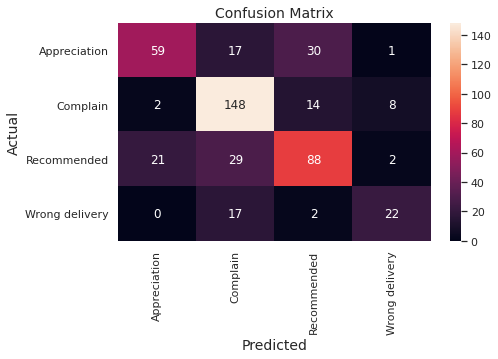

In [358]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7, 4))
sns.set()
f = sns.heatmap(p, annot=True, fmt='d')
plt.title("Confusion Matrix", fontdict={'fontsize': 14})
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual",  fontsize=14)
plt.show()

f.get_figure().savefig("multiclass_confusion_matrix_fastText_munna.jpg", dpi=300, bbox_inches='tight')

In [359]:
target_names = list(le.inverse_transform([0, 1, 2, 3]))
print(classification_report(y_test_k.argmax(axis=1), y_pred.argmax(axis=1), target_names = target_names))

                precision    recall  f1-score   support

  Appreciation       0.72      0.55      0.62       107
      Complain       0.70      0.86      0.77       172
   Recommended       0.66      0.63      0.64       140
Wrong delivery       0.67      0.54      0.59        41

      accuracy                           0.69       460
     macro avg       0.69      0.64      0.66       460
  weighted avg       0.69      0.69      0.68       460

